## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [11]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [12]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
elif torch.backends.mps.is_available():
    print("The code will run on MPS (Apple Silicon GPU).")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [13]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [14]:
size = 128

train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
train_transforms_extra = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor()
    ]
)
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 128

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
trainset_extra = Hotdog_NotHotdog(train=True, transform=train_transforms_extra)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
train_loader_extra = DataLoader(trainset_extra, batch_size=batch_size, shuffle=True)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

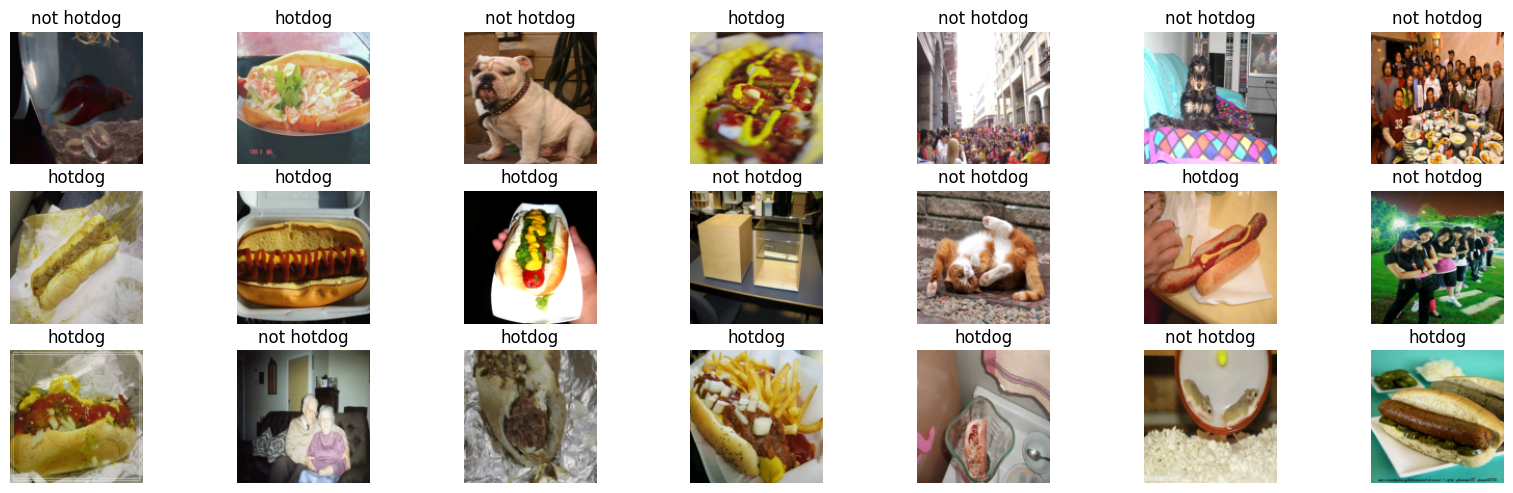

In [15]:
images, labels = next(iter(train_loader_extra))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
class DogNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),                         # (32, 128, 128) -> (32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),                         # (32, 128, 128) -> (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # (32, 128, 128) -> (32, 64, 64)
            nn.Dropout2d(p=0.10),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),                         # (64, 64, 64) -> (64, 64, 64)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),                         # (64, 64, 64) -> (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # (64, 64, 64) -> (64, 32, 32)
            nn.Dropout2d(p=0.10),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),                        # (128, 32, 32) -> (128, 32, 32)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),                        # (128, 32, 32) -> (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # (128, 32, 32) -> (128, 16, 16)
            nn.Dropout2d(p=0.10),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),                        # (256, 16, 16) -> (256, 16, 16)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),                        # (256, 16, 16) -> (256, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # (256, 16, 16) -> (256, 8, 8)
            nn.Dropout2d(p=0.10),

            # Head
            nn.MaxPool2d(kernel_size=2, stride=2),      # (128, 8, 8) -> (128, 4, 4)
            nn.Flatten(),                               # -> (B, 4096)
            nn.Linear(4096, 64),
            nn.ReLU(),
            nn.Dropout(p=0.10),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

HotNotDog(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=262144, out_features=1000, bias=True)
 

In [7]:
from torchvision.models import resnet18, ResNet
from torchvision.models import ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class LinearHead(nn.Module):
    def __init__(self, resnet_model: ResNet, out_features: int = 2):
        super(LinearHead, self).__init__()
        self.fc = nn.Linear(resnet_model.fc.out_features, out_features)
        self.softmax = nn.Softmax(dim=1)
        self.resnet_model = resnet_model
    
    def forward(self, x):
        x = self.resnet_model(x)
        x = self.fc(x)
        return x
    
model_resnet = LinearHead(resnet).to(device)

In [16]:
num_epochs = 50

optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Best accuracy tracking
best_test_acc = 0.0
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model_resnet.train()
    train_correct = 0
    train_loss = 0.0
    for minibatch_no, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_resnet(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # Track training loss and accuracy
        train_loss += loss.item()
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()

    # Compute average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(trainset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Testing phase
    model_resnet.eval()
    test_correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_resnet(data)
            test_loss += F.cross_entropy(output, target).item()
            predicted = output.argmax(1)
            test_correct += (target == predicted).sum().cpu().item()
    
    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(testset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    
    # Save model if test accuracy improves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_resnet.state_dict(), best_model_path)
        print(f"\tNew best test accuracy {100*test_acc:.1f}% at epoch {epoch+1}, model saved to {best_model_path}")

Epoch 1/50
	New best test accuracy 73.6% at epoch 1, model saved to best_model.pth
Epoch 2/50
Epoch 3/50
	New best test accuracy 88.9% at epoch 3, model saved to best_model.pth
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
	New best test accuracy 88.9% at epoch 8, model saved to best_model.pth
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
	New best test accuracy 89.3% at epoch 28, model saved to best_model.pth
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [200]:
custom_hist = np.loadtxt("message.txt")
training_acc_cnn, test_acc_cnn, train_loss_cnn, test_loss_cnn = custom_hist[:, 0],custom_hist[:, 1],custom_hist[:, 2],custom_hist[:, 3]


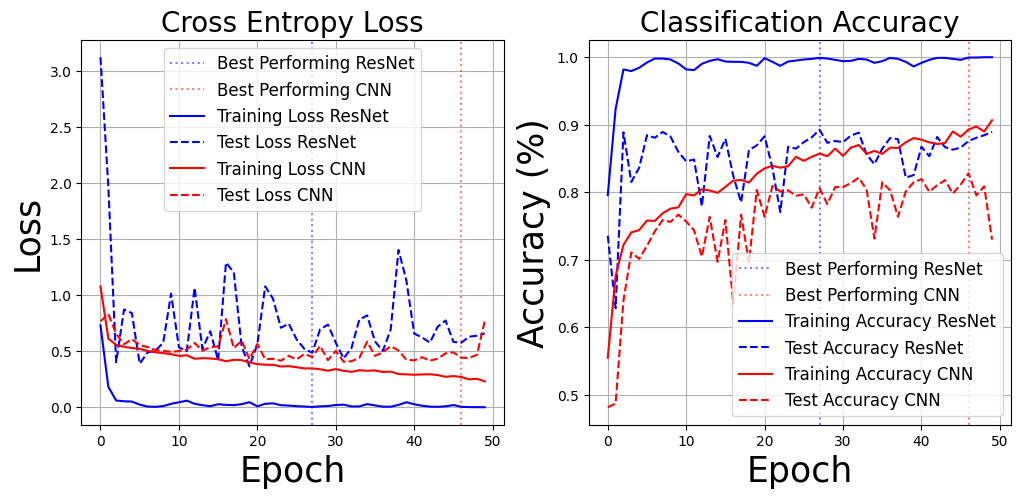

(0.48647423113385835, 0.8925886143931256)

In [208]:

# Plot training and test loss - vertical line at epoch 28
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# alpha = 0.5
plt.axvline(x=27, color='blue', linestyle='dotted', label='Best Performing ResNet', alpha=0.5)
plt.axvline(x=46, color='red', linestyle='dotted', label='Best Performing CNN', alpha=0.5)
plt.plot(train_losses, label='Training Loss ResNet', color='blue')
plt.plot(test_losses, label='Test Loss ResNet', color='blue', linestyle='--')
plt.plot(train_loss_cnn, label='Training Loss CNN', color='red')
plt.plot(test_loss_cnn, label='Test Loss CNN', color='red', linestyle='--')
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.title('Cross Entropy Loss', fontsize=20)
plt.legend(fontsize=12)
plt.grid()
# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.axvline(x=27, color='blue', linestyle='dotted', label='Best Performing ResNet', alpha=0.5)
plt.axvline(x=46, color='red', linestyle='dotted', label='Best Performing CNN', alpha=0.5)
plt.plot(train_accuracies, label='Training Accuracy ResNet', color='blue')
plt.plot(test_accuracies, label='Test Accuracy ResNet', color='blue', linestyle='--')
plt.plot(training_acc_cnn, label='Training Accuracy CNN', color='red')
plt.plot(test_acc_cnn, label='Test Accuracy CNN', color='red', linestyle='--')
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Accuracy (%)', fontsize=25)
plt.title('Classification Accuracy', fontsize=20)
# increase font size of legend
plt.legend(fontsize=12)
plt.grid()
plt.show()

test_losses[27], test_accuracies[27]

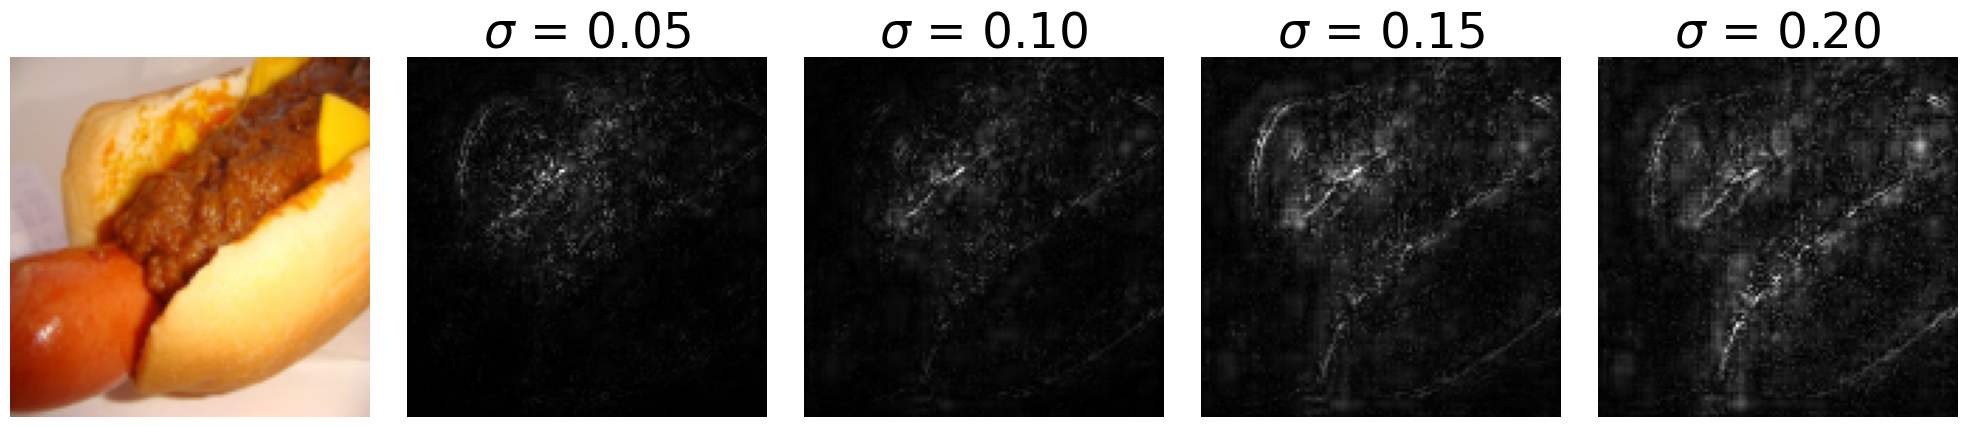

'Original Image\n (predicted: hotdog)\n(ground truth: hotdog)'

In [ ]:
def compute_smoothgrad(model: LinearHead, input_tensor: torch.Tensor, target: int, nt_samples: int=20, stdev: float=0.15):
    model.eval()
    grads = []
    for _ in range(nt_samples):
        
        noisy_input = input_tensor + torch.randn_like(input_tensor) * stdev
        noisy_input.retain_grad()
        
        output = model(noisy_input)
        
        model.zero_grad()
        output[0, target].backward()

        grads.append(noisy_input.grad.data)
    
    smooth_grad = torch.stack(grads).mean(dim=0)
    return smooth_grad

# Load the best model
best_model = LinearHead(resnet).to(device)
best_model.load_state_dict(torch.load(best_model_path))

# Get a sample from the test set
sample_data, sample_target = testset[0]
sample_data = sample_data.reshape(1, *sample_data.shape).to(device)
sample_target = torch.tensor([sample_target]).to(device)
sample_data.requires_grad = True

# Std Values
stdev_values = np.arange(0.05, 0.25, 0.05)

# Compute SmoothGrad for each std value
smooth_grads = []
for stdev in stdev_values:
    smooth_grad = compute_smoothgrad(best_model, sample_data, sample_target, nt_samples=50, stdev=stdev)
    
    smooth_grad_np = smooth_grad.squeeze().cpu().numpy()
    smooth_grad_np = np.abs(smooth_grad_np).sum(axis=0)

    if stdev > 0:
        smooth_grad_np = (smooth_grad_np - smooth_grad_np.min()) / (smooth_grad_np.max() - smooth_grad_np.min() + 1e-8)
    smooth_grads.append(smooth_grad_np)

sample_data_np = sample_data.squeeze().cpu().detach().numpy()
sample_data_np = (sample_data_np - sample_data_np.min()) / (sample_data_np.max() - sample_data_np.min())

n_cols = 5
n_rows = (len(stdev_values) + 1) // n_cols + 1
plt.figure(figsize=(n_cols * 4, n_rows * 4))

predicted_class = best_model(sample_data).argmax(1).item()

plt.subplot(n_rows, n_cols, 1)
plt.imshow(np.transpose(sample_data_np, (1, 2, 0)))
plt.axis('off')

for i, (stdev, smooth_grad_np) in enumerate(zip(stdev_values, smooth_grads), start=2):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(smooth_grad_np, cmap='gray')
    plt.title(r'$\sigma$ = {:.2f}'.format(stdev), fontsize=35)
    plt.axis('off')

plt.tight_layout()
plt.show()

f'Original Image\n (predicted: {["hotdog", "not hotdog"][predicted_class]})\n(ground truth: {["hotdog", "not hotdog"][sample_target]})'